# Clustering applied for LOCO

### Testing to see improvements on LOCO by grouping countries with similar patterns

### Imports

In [37]:
import pandas as pd
import numpy as np
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform

warnings.filterwarnings("ignore")

### Config

In [38]:
TARGET_VARIABLES = ['co2', 'gdp', 'primary_energy_consumption']

G20_COUNTRIES = [
    'United States', 'China', 'Japan', 'Germany', 
    'United Kingdom', 'France', 'Italy', 'Canada',
    'Brazil', 'Russia', 'India', 'Australia', 
    'Mexico', 'Indonesia', 'Turkey', 'Saudi Arabia',
    'South Africa', 'Argentina', 'South Korea'
]

DEVELOPED_COUNTRIES = [
    'United States', 'Japan', 'Germany', 'United Kingdom',
    'France', 'Italy', 'Canada', 'Australia', 'South Korea'
]

DEVELOPING_COUNTRIES = [
    'China', 'Brazil', 'Russia', 'India', 'Mexico', 'Indonesia',
    'Turkey', 'Saudi Arabia', 'South Africa', 'Argentina'
]


### Data Load

In [39]:
def load_data(save_dir='data_export'):
    lag_path = os.path.join(save_dir, 'lag_df_1965.pkl')
    lag_df = pd.read_pickle(lag_path)
    print(f"Data Shape: {lag_df.shape}")
    return lag_df

In [40]:
# Loading corr_matrix for clustering
def load_correlation_matrix(target, save_dir='data_export/05_01_country_correlation'):
    corr_path = os.path.join(save_dir, f'{target}_correlations.csv')
    corr_df = pd.read_csv(corr_path, index_col=0)
    return corr_df

### Clustering Funcs

In [41]:
# Convert corr into distance for hierarchical clustering
def correlation_to_distance(corr_matrix):
    """
    distance = 1 - correlation
    (high corr means low distance)
    """
    # Ensure correlation matrix is symmetric
    corr_matrix = (corr_matrix + corr_matrix.T) / 2
    
    # Convert correlation to distance
    distance_matrix = 1 - corr_matrix
    
    # Ensure diagonal is exactly 0
    np.fill_diagonal(distance_matrix.values, 0)
    
    return distance_matrix

In [42]:
# Show tree structure grouping
def hierarchical_clustering(distance_matrix, method='ward'):
    """
    ward: minimise within-cluster variance -> best for balanced clusters
    """
    condensed_dist_matrix = squareform(distance_matrix.values)

    linkage_matrix = linkage(condensed_dist_matrix, method, method)

    return linkage_matrix

In [43]:
# Tree structure -> discrete cluster to label each country
def cluster_labels(linkage_matrix, distance_matrix, n_clusters=3):
    labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

    cluster_dict = dict(zip(distance_matrix.index, labels))

    return cluster_dict

### Visualise

In [44]:
# Show dendrogram tree
def plot_dendrogram(linkage_matrix, country_names, target, save_dir='data_export/05_02_clustering'):
    os.makedirs(save_dir, exist_ok=True)

    fig, ax = plt.subplots(figsize=(14, 8))

    # Dendrogram
    dendrogram(linkage_matrix, labels=country_names, ax=ax, leaf_font_size=10, color_threshold=0.7)

    ax.set_title(f'Hierarchical Clustering Dendrogram - {target.upper()}', fontsize=15, pad=20)
    ax.set_xlabel('Country', fontsize=11)
    ax.set_ylabel('Distance', fontsize=11)

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plot_path = os.path.join(save_dir, f'{target}_dendrogram.png')
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')

    return fig

In [45]:
# Heatmap
def plot_clustered_heatmap(corr_matrix, cluster_dict, target, save_dir='data_export/05_02_clustering'):
    os.makedirs(save_dir, exist_ok=True)

    sorted_countries = sorted(corr_matrix.index, key=lambda x: cluster_dict[x])
    reordered_corr = corr_matrix.loc[sorted_countries, sorted_countries]

    fig, ax = plt.subplots(figsize=(12, 10))

    sns.heatmap(reordered_corr, annot=False, cmap='RdBu_r', center=0, vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'}, ax=ax, square=True)

    ax.set_title(f'Clustered Correlation Matrix - {target.upper()}', fontsize=15, pad=20)
    ax.set_xlabel('Countries (ordered by cluster)', fontsize=11)
    ax.set_ylabel('Countries (ordered by cluster)', fontsize=11)

    cluster_sizes = pd.Series(cluster_dict).value_counts().sort_index()
    cumsum = np.cumsum([0] + cluster_sizes.tolist())
    for boundary in cumsum[1:-1]:
        ax.axhline(boundary, color='black', linewidth=2)
        ax.axvline(boundary, color='black', linewidth=2)
    
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()

    plot_path = os.path.join(save_dir, f'{target}_clustered_heatmap.png')
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    
    return fig

In [46]:
# Show the temporal trends
def plot_cluster_trajectories(data, target, cluster_dict, save_dir='data_export/05_02_clustering'):
    os.makedirs(save_dir, exist_ok=True)

    n_clusters = len(set(cluster_dict.values()))
    fig, axes = plt.subplots(1, n_clusters, figsize=(6*n_clusters, 5))

    if n_clusters == 1:
        axes = [axes]
    
    for cluster_id in range(1, n_clusters + 1):
        ax = axes[cluster_id - 1]
        
        cluster_countries = [c for c, cid in cluster_dict.items() if cid == cluster_id]
        
        # Plot each country's trajectory
        for country in cluster_countries:
            country_data = data[data['country'] == country].sort_values('year')
            if target in country_data.columns:
                ax.plot(country_data['year'], country_data[target], alpha=0.3, linewidth=1, label=country)
        
        # Calculate and plot cluster average
        cluster_data = data[data['country'].isin(cluster_countries)].groupby('year')[target].mean()
        ax.plot(cluster_data.index, cluster_data.values, color='black', linewidth=3, label='Cluster Average')
        
        ax.set_title(f'Cluster {cluster_id} ({len(cluster_countries)} countries)', fontsize=12)
        ax.set_xlabel('Year', fontsize=10)
        ax.set_ylabel(target.upper(), fontsize=10)
        ax.legend(fontsize=7, loc='best')
    
    plt.suptitle(f'Cluster Trajectories - {target.upper()}', fontsize=15)
    plt.tight_layout()
    
    plot_path = os.path.join(save_dir, f'{target}_cluster_trajectories.png')
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    
    return fig

### Analyse

In [47]:
def analyse_cluster(cluster_dict, target):
    print(f"Clutser analysis {target.upper()}")

    n_clusters = len(set(cluster_dict.values()))
    print(f"\nNumber of clusters: {n_clusters}")

    for cluster_id in range(1, n_clusters + 1):
        cluster_countries = [c for c, cid in cluster_dict.items() if cid == cluster_id]
        
        print(f"\nCluster {cluster_id} ({len(cluster_countries)} countries):")
        for country in sorted(cluster_countries):

            # developed or developing
            if country in DEVELOPED_COUNTRIES:
                label = "(Developed)"
            elif country in DEVELOPING_COUNTRIES:
                label = "(Developing)"
            else:
                label = ""
            print(f"  - {country} {label}")

In [48]:
def save_cluster_results(cluster_dict, target, save_dir='data_export/05_02_clustering'):
    os.makedirs(save_dir, exist_ok=True)
    
    cluster_df = pd.DataFrame.from_dict(cluster_dict, orient='index', columns=['cluster'])
    cluster_df.index.name = 'country'
    cluster_df = cluster_df.sort_values('cluster')
    
    save_path = os.path.join(save_dir, f'{target}_cluster_assignments.csv')
    cluster_df.to_csv(save_path)
    
    return cluster_df

### Run

In [49]:
def run_clustering(target, n_clusters=3, save_dir='data_export/05_02_clustering'):
    os.makedirs(save_dir, exist_ok=True)

    print(f"\nHierarchical Clustering for {target.upper()}")

    corr_matrix = load_correlation_matrix(target)
    print(f"{corr_matrix.shape[0]} countries")

    distance_matrix = correlation_to_distance(corr_matrix)

    linkage_matrix = hierarchical_clustering(distance_matrix)

    cluster_dict = cluster_labels(linkage_matrix, distance_matrix, n_clusters)
    
    analyse_cluster(cluster_dict, target)

    fig_dendro = plot_dendrogram(linkage_matrix, distance_matrix.index, target, save_dir)
    plt.show()

    fig_heatmap = plot_clustered_heatmap(corr_matrix, cluster_dict, target, save_dir)
    plt.show()

    data = load_data()
    fig_traj = plot_cluster_trajectories(data, target, cluster_dict, save_dir)
    plt.show()

    cluster_df = save_cluster_results(cluster_dict, target, save_dir)
    
    results = {
        'cluster_dict': cluster_dict,
        'cluster_df': cluster_df,
        'linkage_matrix': linkage_matrix,
        'distance_matrix': distance_matrix
    }
    
    return results

In [50]:
# Optimal n of cluters
def plot_elbow_analysis(linkage_matrix, distance_matrix, target, max_clusters=8, save_dir='data_export/05_02_clustering'):
    os.makedirs(save_dir, exist_ok=True)

    # within cluster sum of squares for k
    ss = []
    k_range = range(2, max_clusters + 1)

    for k in k_range:
        labels = fcluster(linkage_matrix, k, criterion='maxclust')
        
        # Calculate within cluster sum of squares
        total_ss = 0
        for cluster_id in range(1, k + 1):
            cluster_mask = labels == cluster_id
            cluster_indices = np.where(cluster_mask)[0]
            
            if len(cluster_indices) > 1:
                cluster_distances = distance_matrix.values[np.ix_(cluster_indices, cluster_indices)]
                total_ss += np.sum(cluster_distances) / (2 * len(cluster_indices))
        
        ss.append(total_ss)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(k_range, ss, marker='o', linewidth=2, markersize=8)
    ax.set_xlabel('Number of Clusters', fontsize=12)
    ax.set_ylabel('Within Cluster Sum of Squares', fontsize=11)
    ax.set_title(f'Elbow Curve - {target.upper()}', fontsize=15)

    for k, w in zip(k_range, ss):
        ax.text(k, w, f'{w:.2f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()

    plot_path = os.path.join(save_dir, f'{target}_elbow_analysis.png')
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')

    return fig

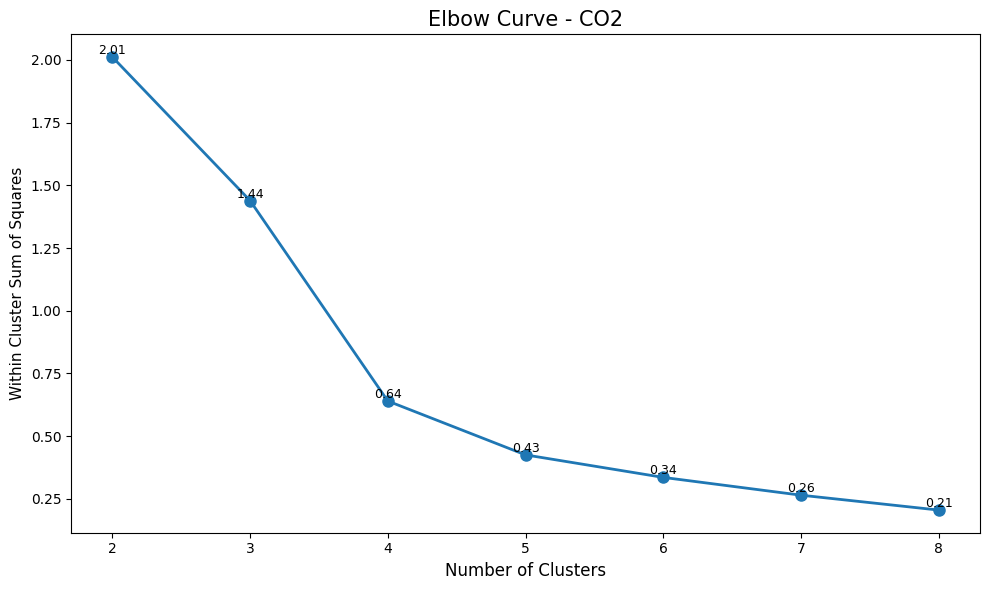

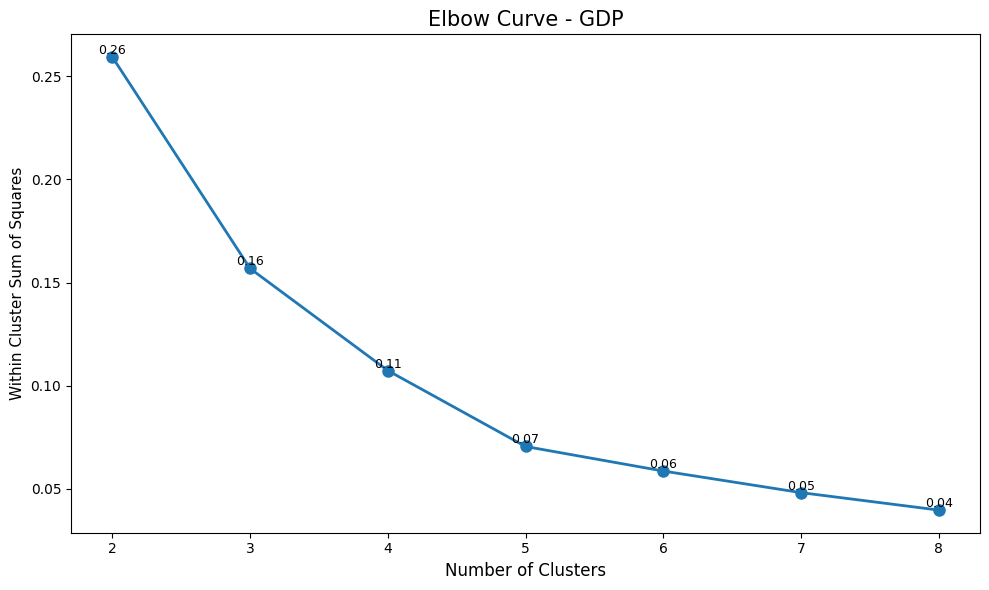

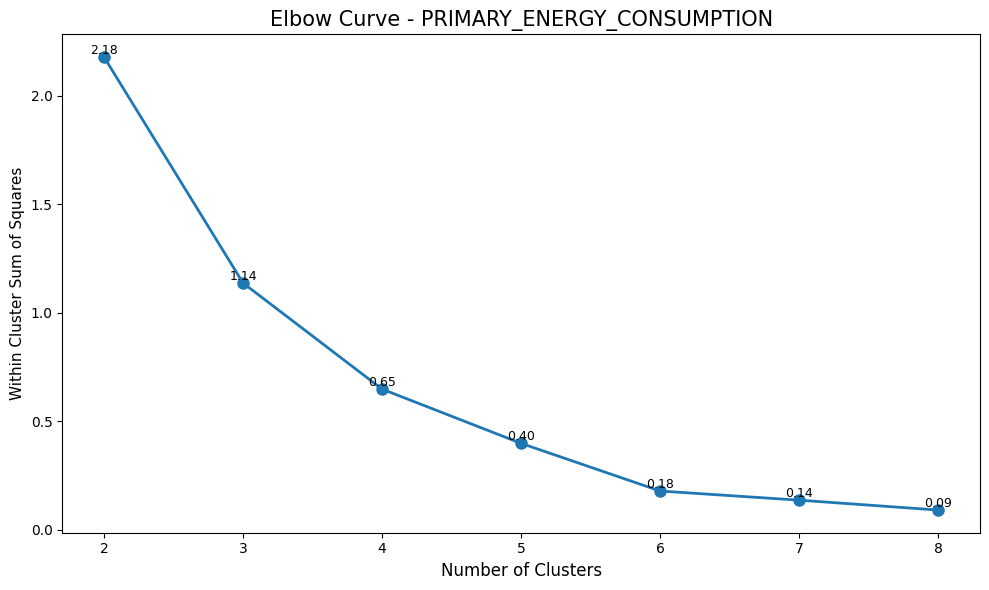

In [51]:
for target in TARGET_VARIABLES:
    corr_matrix = load_correlation_matrix(target)
    distance_matrix = correlation_to_distance(corr_matrix)
    linkage_matrix = hierarchical_clustering(distance_matrix)
    
    fig = plot_elbow_analysis(linkage_matrix, distance_matrix, target)
    plt.show()

In [52]:
def run_all(n_clusters=3):
    all_results = {}
    
    for target in TARGET_VARIABLES:
        results = run_clustering(target, n_clusters=n_clusters)
        all_results[target] = results

    return all_results


Hierarchical Clustering for CO2
19 countries
Clutser analysis CO2

Number of clusters: 4

Cluster 1 (3 countries):
  - Italy (Developed)
  - Japan (Developed)
  - United States (Developed)

Cluster 2 (12 countries):
  - Argentina (Developing)
  - Australia (Developed)
  - Brazil (Developing)
  - Canada (Developed)
  - China (Developing)
  - India (Developing)
  - Indonesia (Developing)
  - Mexico (Developing)
  - Saudi Arabia (Developing)
  - South Africa (Developing)
  - South Korea (Developed)
  - Turkey (Developing)

Cluster 3 (3 countries):
  - France (Developed)
  - Germany (Developed)
  - United Kingdom (Developed)

Cluster 4 (1 countries):
  - Russia (Developing)


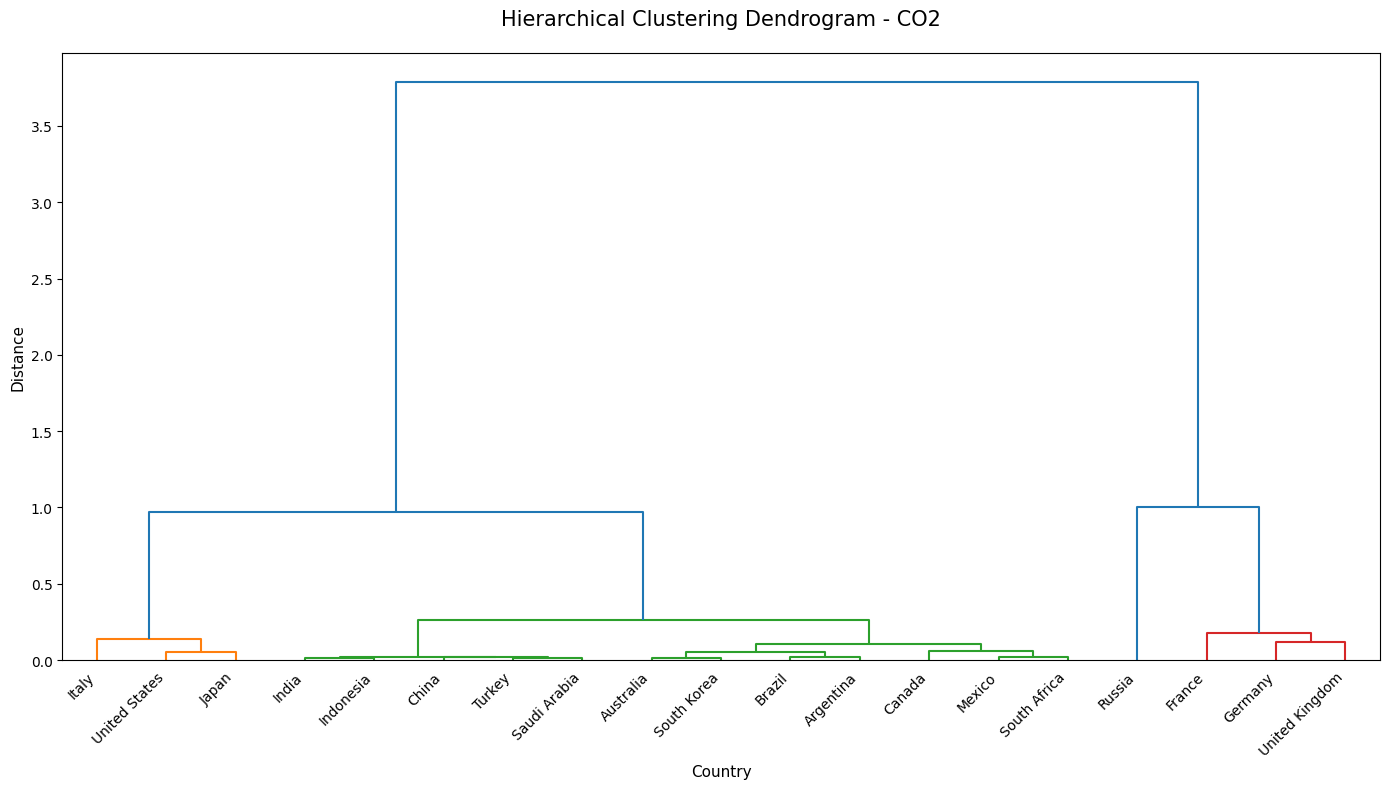

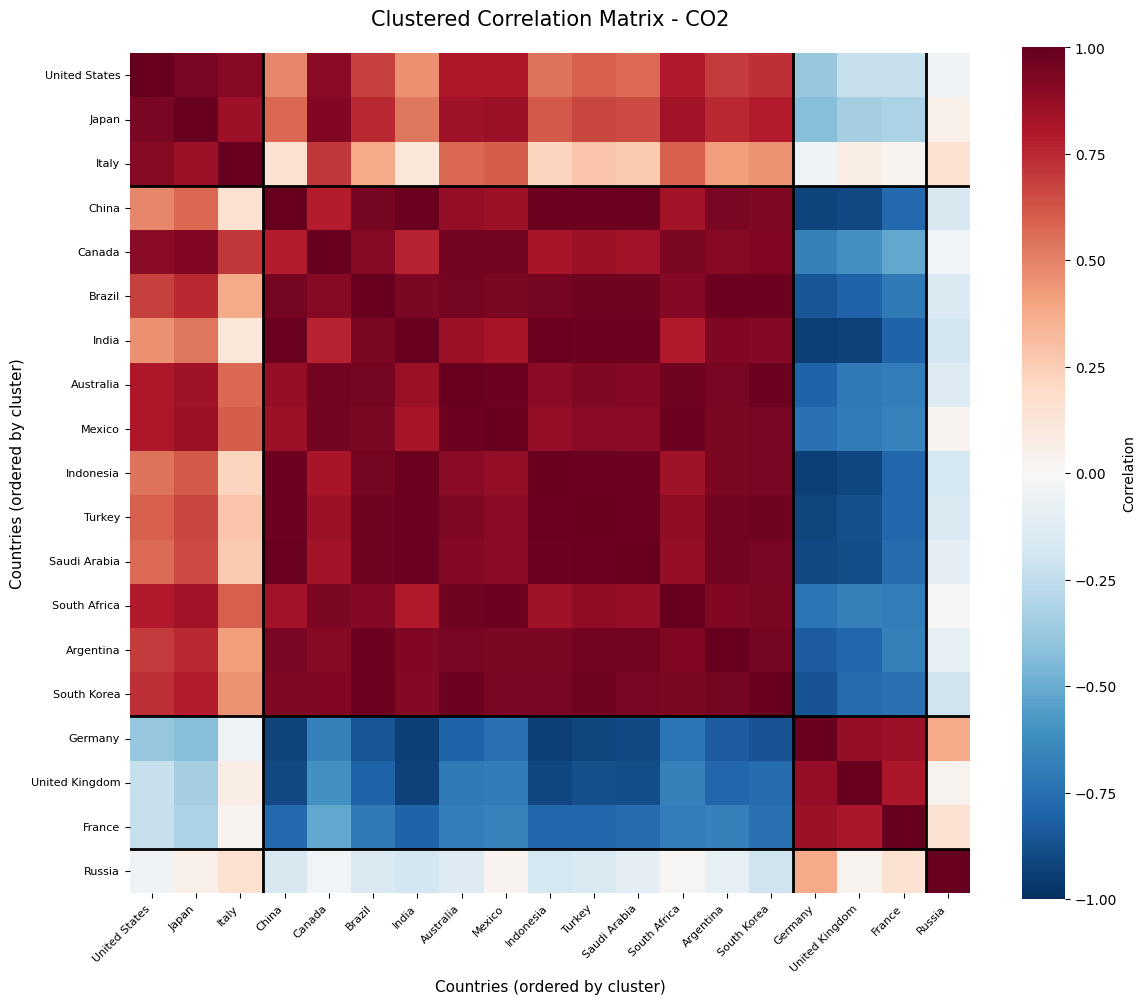

Data Shape: (1138, 992)


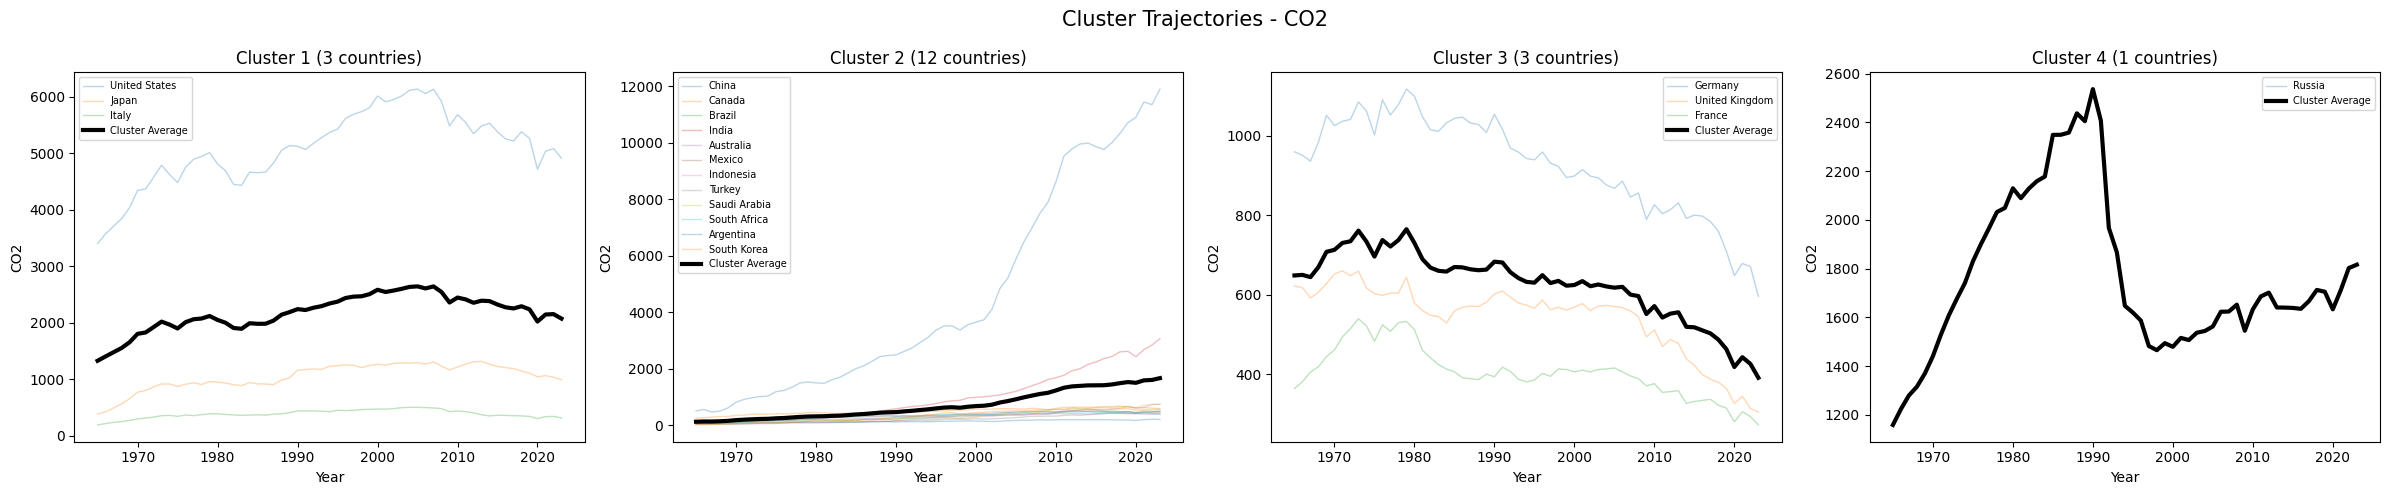


Hierarchical Clustering for GDP
19 countries
Clutser analysis GDP

Number of clusters: 4

Cluster 1 (5 countries):
  - China (Developing)
  - India (Developing)
  - Indonesia (Developing)
  - Saudi Arabia (Developing)
  - Turkey (Developing)

Cluster 2 (1 countries):
  - Russia (Developing)

Cluster 3 (2 countries):
  - Italy (Developed)
  - Japan (Developed)

Cluster 4 (11 countries):
  - Argentina (Developing)
  - Australia (Developed)
  - Brazil (Developing)
  - Canada (Developed)
  - France (Developed)
  - Germany (Developed)
  - Mexico (Developing)
  - South Africa (Developing)
  - South Korea (Developed)
  - United Kingdom (Developed)
  - United States (Developed)


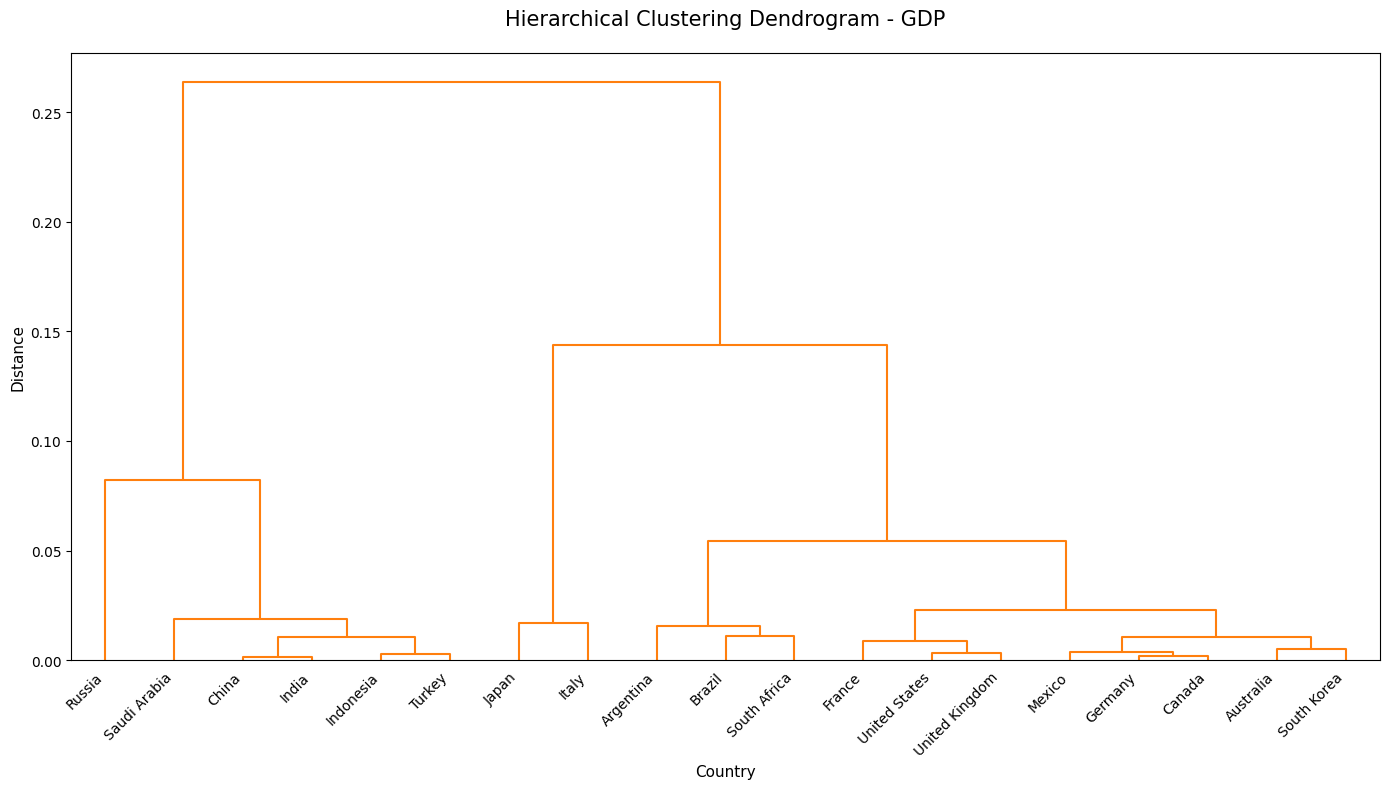

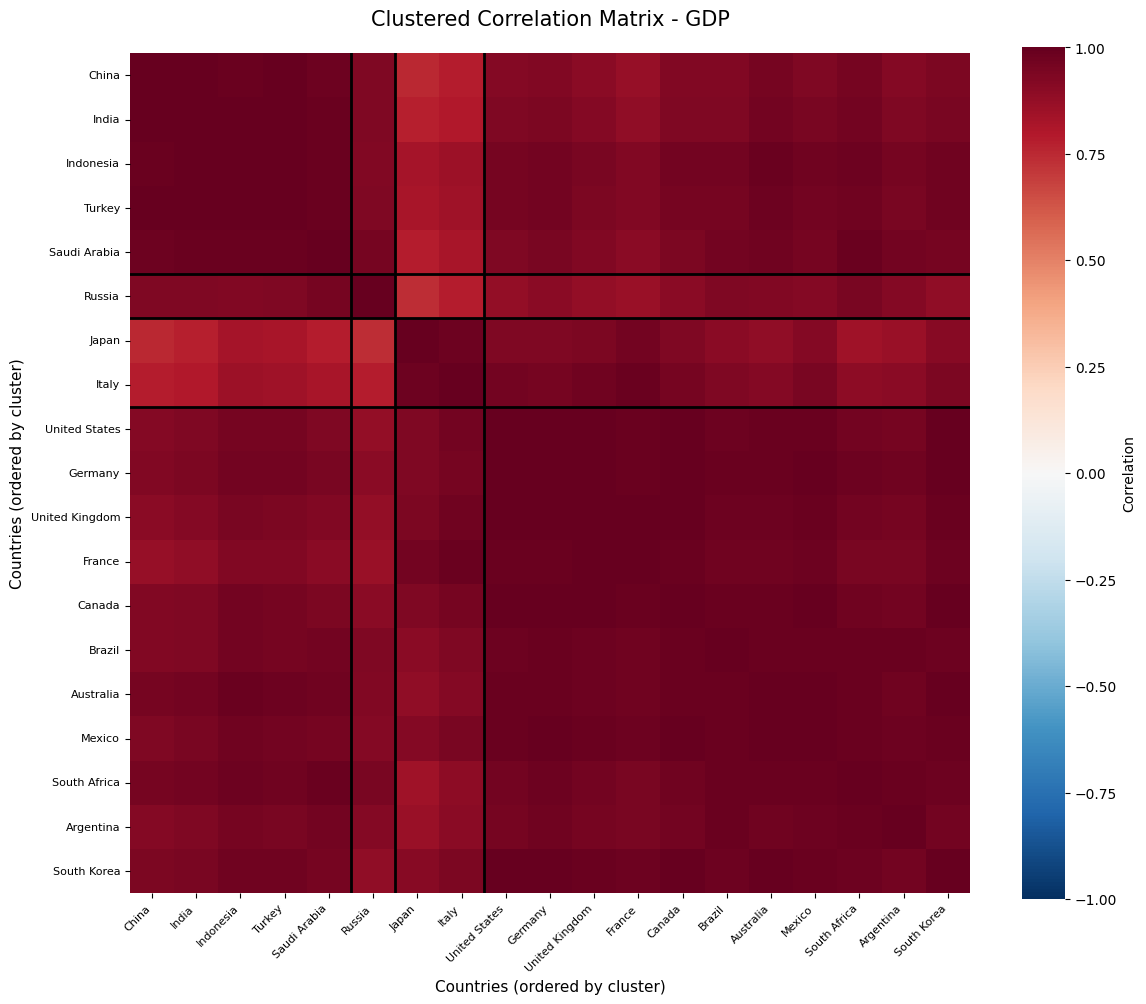

Data Shape: (1138, 992)


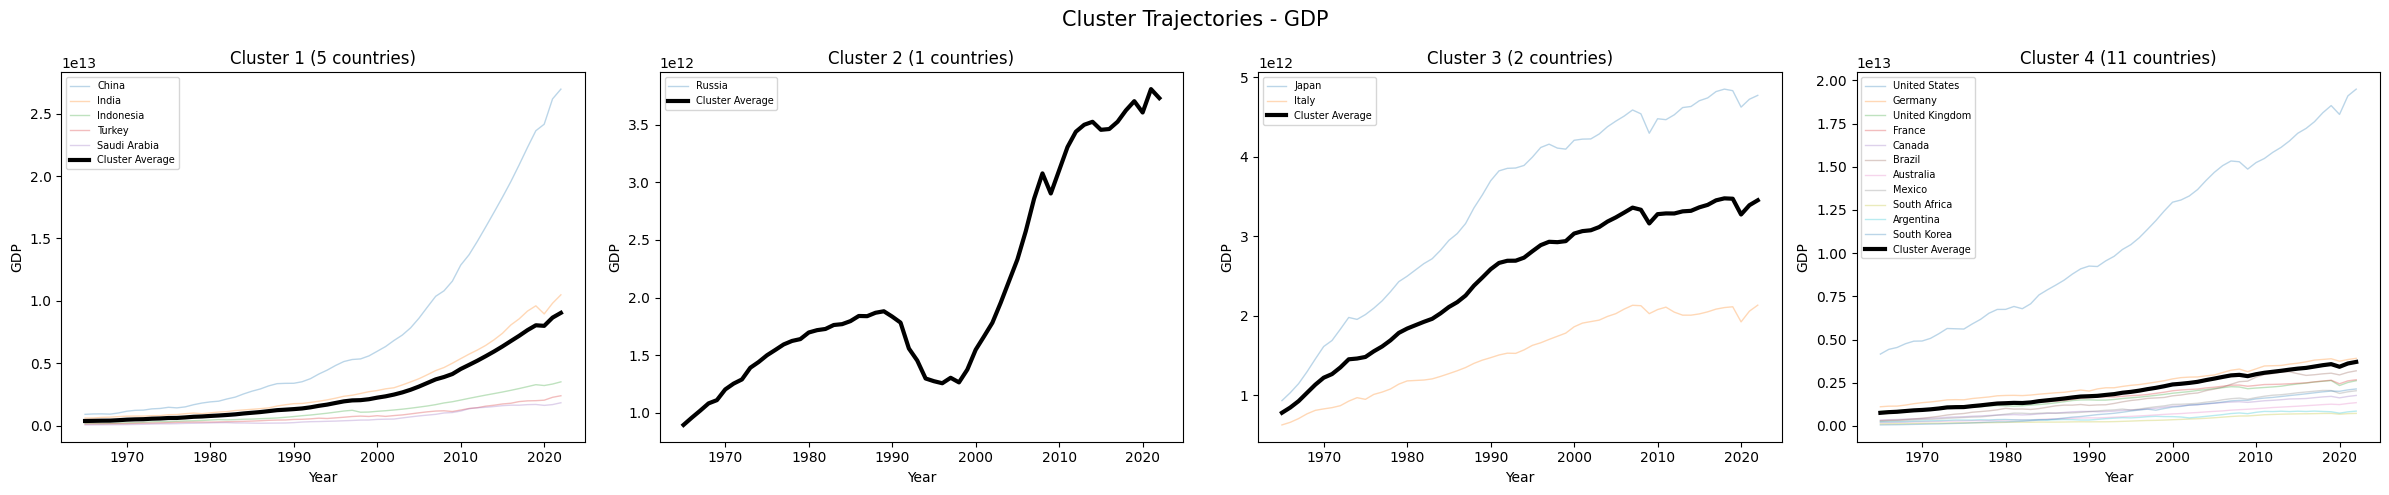


Hierarchical Clustering for PRIMARY_ENERGY_CONSUMPTION
19 countries
Clutser analysis PRIMARY_ENERGY_CONSUMPTION

Number of clusters: 4

Cluster 1 (13 countries):
  - Argentina (Developing)
  - Australia (Developed)
  - Brazil (Developing)
  - Canada (Developed)
  - China (Developing)
  - India (Developing)
  - Indonesia (Developing)
  - Mexico (Developing)
  - Saudi Arabia (Developing)
  - South Africa (Developing)
  - South Korea (Developed)
  - Turkey (Developing)
  - United States (Developed)

Cluster 2 (3 countries):
  - France (Developed)
  - Italy (Developed)
  - Japan (Developed)

Cluster 3 (2 countries):
  - Germany (Developed)
  - United Kingdom (Developed)

Cluster 4 (1 countries):
  - Russia (Developing)


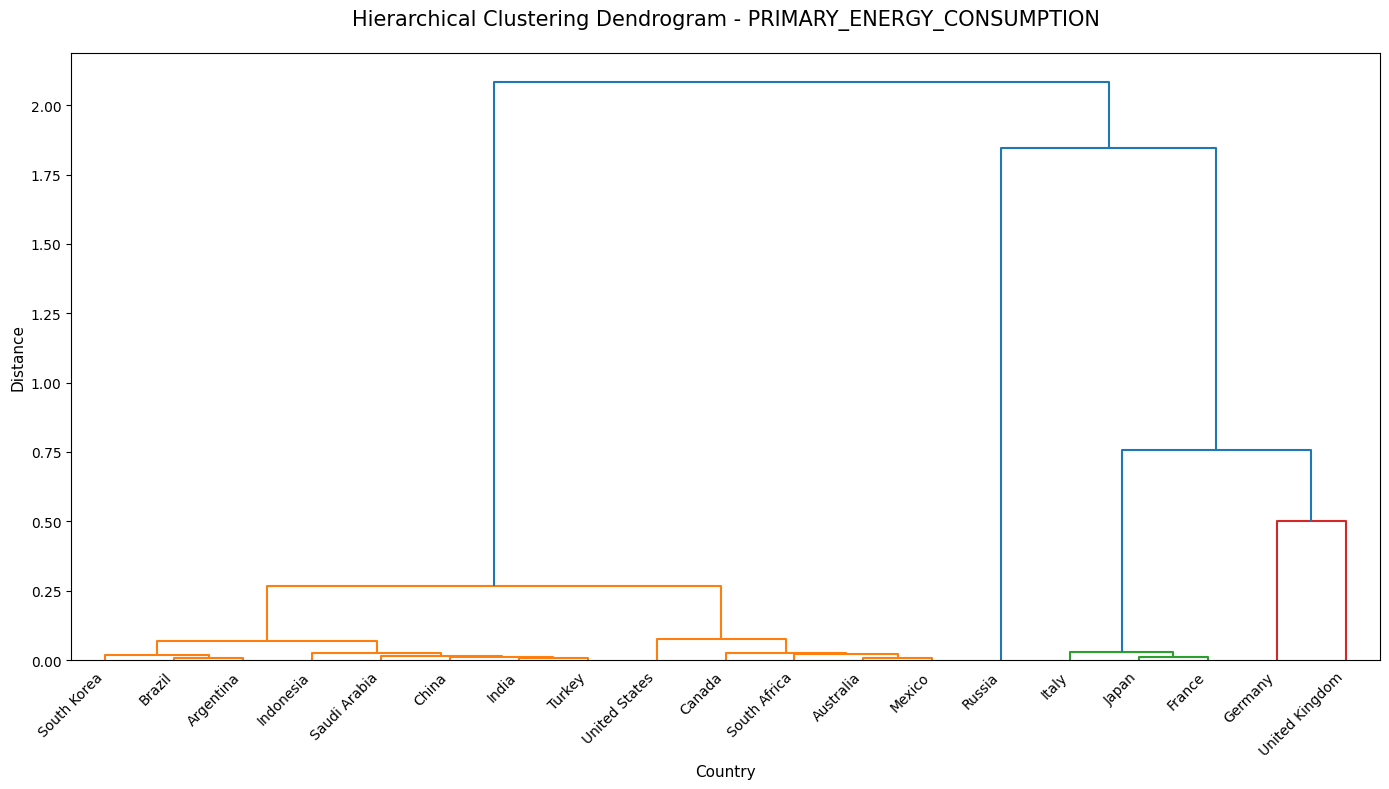

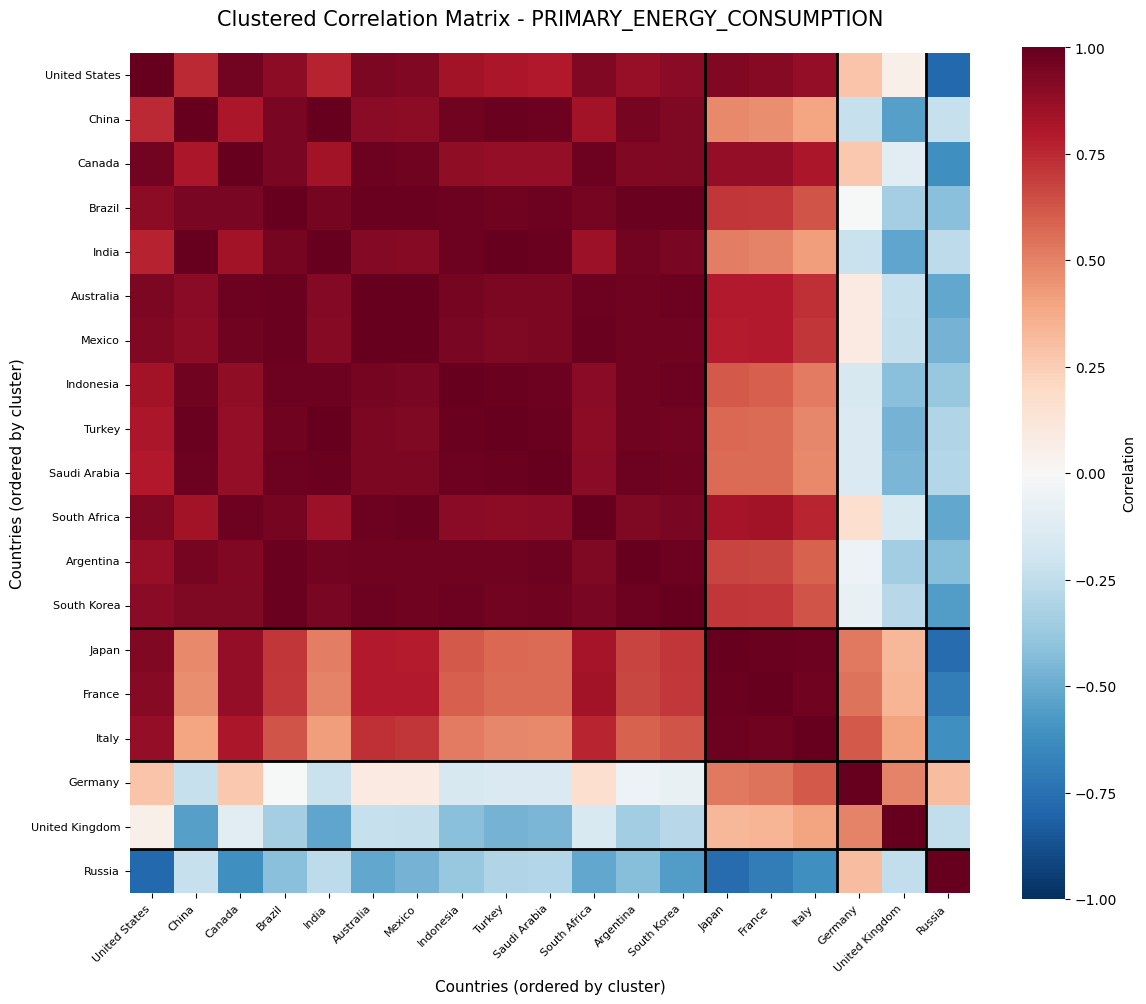

Data Shape: (1138, 992)


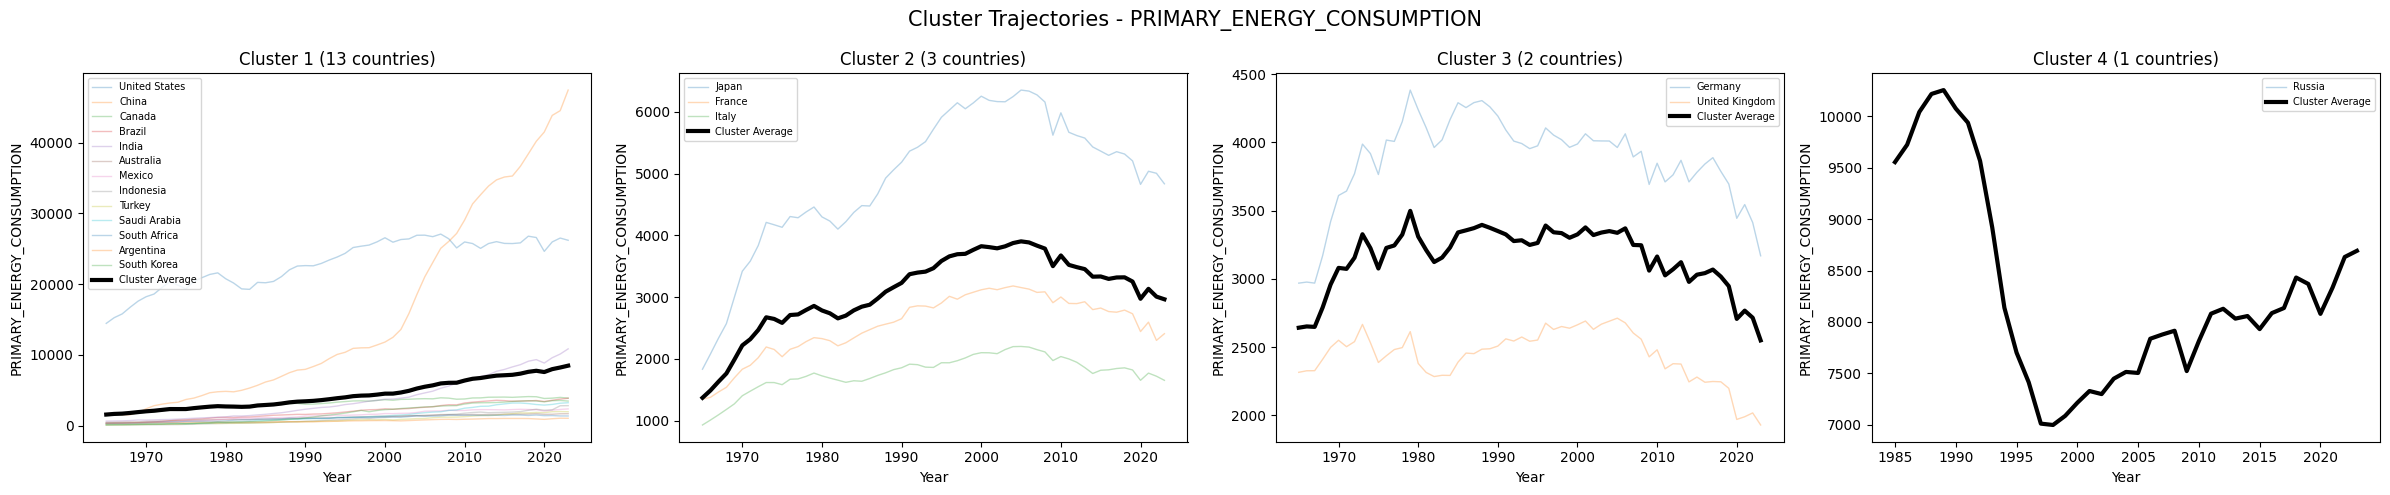

In [53]:
all_results = run_all(n_clusters=4)

### Raw data of Russia

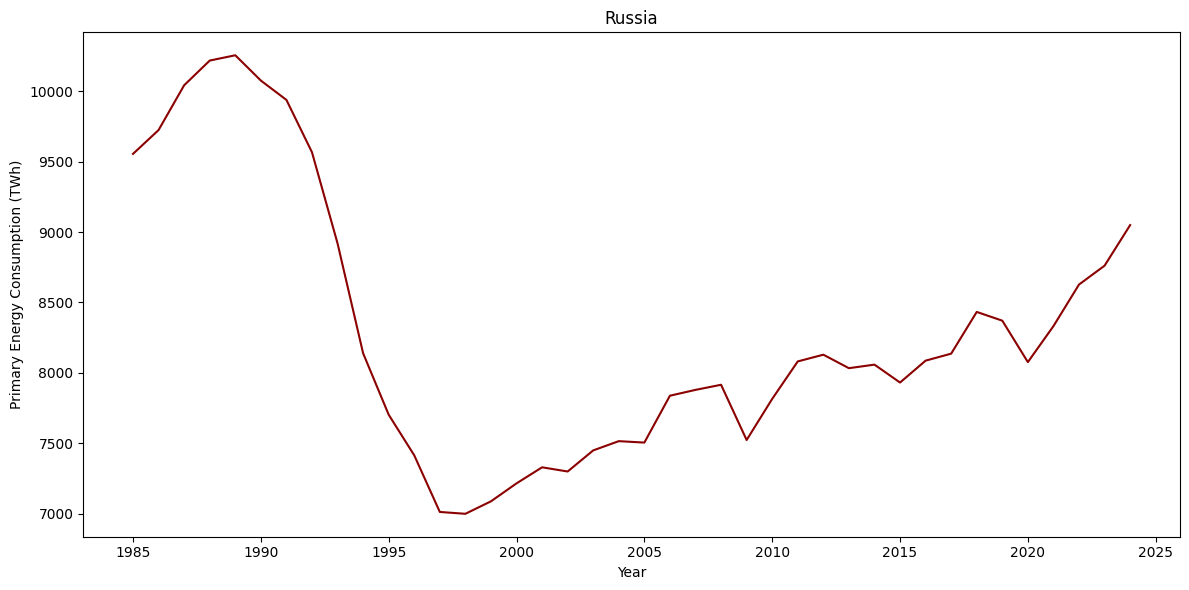

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

url = 'https://raw.githubusercontent.com/owid/energy-data/refs/heads/master/owid-energy-data.csv'
data = pd.read_csv(url)

russia_data = data[data['country'] == 'Russia'].sort_values('year')

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(russia_data['year'], russia_data['primary_energy_consumption'], color='darkred')

ax.set_xlabel('Year')
ax.set_ylabel('Primary Energy Consumption (TWh)')
ax.set_title('Russia')

plt.tight_layout()
plt.show()